# Final Capstone Project

Melissa DiMaio

For my project, I am finding the best neighborhood to open a bagel shop in New York City given several different factors. First, I will be limiting location data to stay close to where our theoretical client lives, in this example Central Queens. Then, I will be examining average rents for different neighborhoods to see where is too expensive. Then, I will use the foursquare API to find the number of bagel shops already present within a  radius of the neighborhood to figure out demand. Finally, I will use k-means clustering to split neighborhoods into different clusters, each cluster with its own pros and cons.   

Step 1: Choosing neighborhoods close to home

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

! pip3 install simplejson
import simplejson as json
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 128 kB 13.3 MB/s eta 0:00:01
/opt/conda/envs/Python-3.7-main

In [4]:
#importing location data
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [5]:
#creating dataframe

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
#limiting data to Queens

queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
queens_data

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138
...,...,...,...,...
76,Queens,Middle Village,40.716415,-73.881143
77,Queens,Malba,40.790602,-73.826678
78,Queens,Hammels,40.587338,-73.805530
79,Queens,Bayswater,40.611322,-73.765968


In [13]:
#finding lat and long values of client's address

address = '67-01 110th St, Queens'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.7297049 -73.8450937


In [10]:
#further limiting location data to central Queens, using min and max lat and log values

queens_data.drop(queens_data[queens_data['Longitude'] < -73.9].index, inplace = True)
queens_data.drop(queens_data[queens_data['Longitude'] > -73.8].index, inplace = True)
queens_data.drop(queens_data[queens_data['Latitude'] > 40.764073].index, inplace = True)
queens_data.drop(queens_data[queens_data['Latitude'] < 40.72526].index, inplace = True)

In [11]:
queens_data

,Borough,Neighborhood,Latitude,Longitude
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
5,Queens,Corona,40.742382,-73.856825
6,Queens,Forest Hills,40.725264,-73.844475
13,Queens,Maspeth,40.725427,-73.896217
16,Queens,Rego Park,40.728974,-73.857827
55,Queens,Queensboro Hill,40.744572,-73.825809
60,Queens,Lefrak City,40.736075,-73.862525
66,Queens,North Corona,40.754071,-73.857518
70,Queens,Pomonok,40.734936,-73.804861


In [14]:
# creating map
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(queens_data['Latitude'], queens_data['Longitude'], queens_data['Borough'], queens_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Step 2: Examining average neighborhood rents and elimating neighborhoods which are too expensive 

In [15]:
# The code was removed by Watson Studio for sharing.

,Neighborhood,Average Rent
0,South Astoria,"$3,017"
1,Hunters Point,"$2,979"
2,Long Island City,"$2,964"
3,Forest Hills,"$2,958"
4,Sunnyside,"$2,906"


In [31]:
#converting prices to float
rents['Average Rent'] = rents['Average Rent'].replace('[\$,]', '', regex=True).astype(float)
rents.head()

,Average Rent
Neighborhood,
South Astoria,3017.0
Hunters Point,2979.0
Long Island City,2964.0
Forest Hills,2958.0
Sunnyside,2906.0


In [32]:
#using inner join to merge dataframes
central_queens = pd.merge(left=queens_data, right=rents, left_on='Neighborhood', right_on='Neighborhood')
central_queens.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rent
0,Queens,Jackson Heights,40.751981,-73.882821,2243.0
1,Queens,Elmhurst,40.744049,-73.881656,2013.0
2,Queens,Corona,40.742382,-73.856825,2090.0
3,Queens,Forest Hills,40.725264,-73.844475,2958.0
4,Queens,Maspeth,40.725427,-73.896217,2034.0


In [33]:
import matplotlib as mp
import matplotlib.pyplot as plt

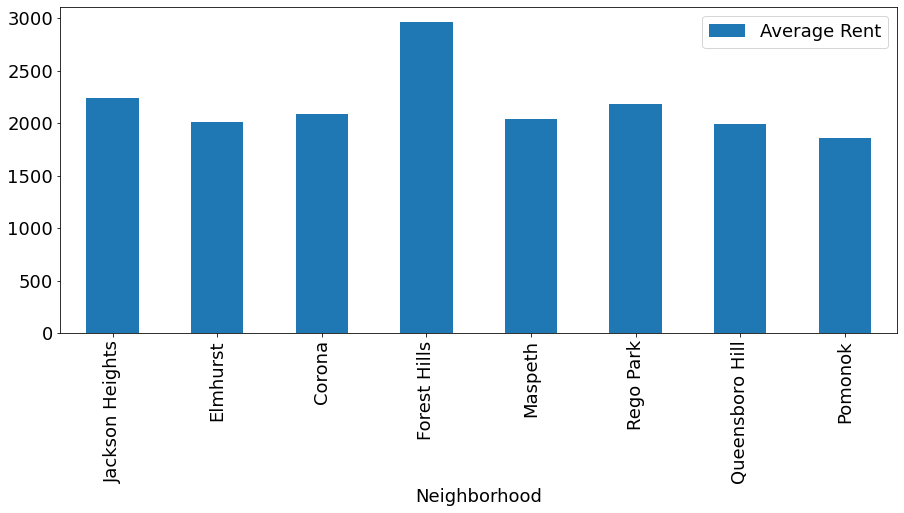

In [34]:
plt.rcParams.update({'font.size': 18})
central_queens.plot(x='Neighborhood', y='Average Rent', kind='bar', figsize=(15, 6))

In [35]:
#decide that forest hills is too expensive, so drop it from dataframe

central_queens.drop(central_queens[central_queens['Neighborhood'] == 'Forest Hills'].index, inplace = True)

In [36]:
central_queens

,Borough,Neighborhood,Latitude,Longitude,Average Rent
0,Queens,Jackson Heights,40.751981,-73.882821,2243.0
1,Queens,Elmhurst,40.744049,-73.881656,2013.0
2,Queens,Corona,40.742382,-73.856825,2090.0
4,Queens,Maspeth,40.725427,-73.896217,2034.0
5,Queens,Rego Park,40.728974,-73.857827,2182.0
6,Queens,Queensboro Hill,40.744572,-73.825809,1994.0
7,Queens,Pomonok,40.734936,-73.804861,1860.0


Step 3: Use foursquare api to find # of bagel places in each neighborhood

In [38]:
CLIENT_ID = 'LZOUGIBPNIQOCFYKOS0C4XNHPA0PWOZFMHSIVXMST4E0Z22U' # your Foursquare ID
CLIENT_SECRET = '5HIBEYILQS5V0FB2IS2HNBN1KHXTEVWCKG2LYEGC2YH153M2' # your Foursquare Secret
ACCESS_TOKEN = 'WHHNONQBN5WIXPZEK3QFBCH5JTMB1FUXLS13S4NVEZSDPKBR' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LZOUGIBPNIQOCFYKOS0C4XNHPA0PWOZFMHSIVXMST4E0Z22U
CLIENT_SECRET:5HIBEYILQS5V0FB2IS2HNBN1KHXTEVWCKG2LYEGC2YH153M2


In [37]:
search_query = 'Bagel'
radius = 500
print(search_query + ' .... OK!')

Bagel .... OK!


In [39]:
#search for each lat and log value, and then record total number by recording rows in dataframe
lat1 = 40.751981
long1 = -73.882821
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat1, long1,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
number1 = dataframe.shape[0]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [41]:
#and again and again (probably could have used a loop but whatev)
lat2, lat3, lat4, lat5, lat6, lat7  = 40.744049, 40.742382, 40.725427, 40.728974, 40.744572, 40.734936
long2, long3, long4, long5, long6, long7 = -73.881656, -73.856825, -73.896217, -73.857827, -73.825809, -73.804861

In [42]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat2, long2,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
number2 = dataframe.shape[0]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [43]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat3, long3,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
number3 = dataframe.shape[0]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [44]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat4, long4,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
number4 = dataframe.shape[0]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [45]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat5, long5,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
number5 = dataframe.shape[0]

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat6, long6,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
number6 = dataframe.shape[0]

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat7, long7,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
venues = results['response']['venues']
dataframe = json_normalize(venues)
number7 = dataframe.shape[0]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [46]:
number7

1

In [48]:
#put into dataframe
bagels = {'Neighborhood' : ['Jackson Heights', 'Elmhurst', 'Corona', 'Maspeth', 'Rego Park', 'Queensboro Hill', 'Pomonok'], 'Number of Bagel Places in Radius' : [number1, number2, number3, number4, number5, number6, number7]}  
bagels = pd.DataFrame.from_dict(bagels)

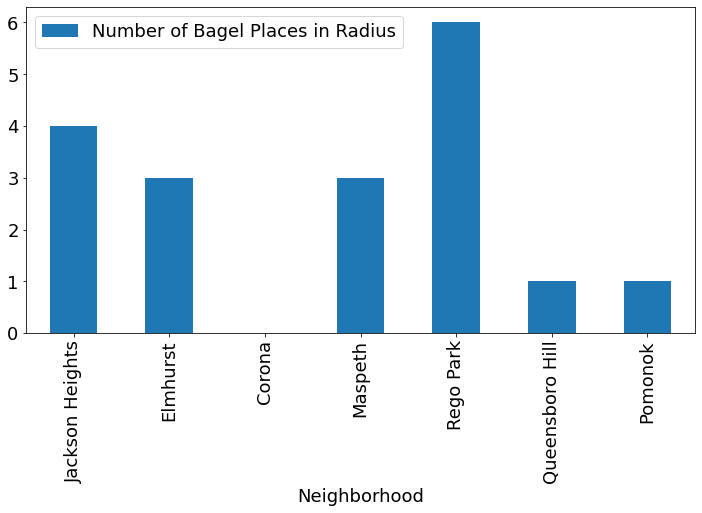

In [49]:
bagels.plot(x = 'Neighborhood', y= 'Number of Bagel Places in Radius', kind='bar', figsize=(12, 6))

In [51]:
#merge all into one dataframe
merged = pd.merge(left=central_queens, right=bagels, left_on='Neighborhood', right_on='Neighborhood')
merged

,Borough,Neighborhood,Latitude,Longitude,Average Rent,Number of Bagel Places in Radius
0,Queens,Jackson Heights,40.751981,-73.882821,2243.0,4
1,Queens,Elmhurst,40.744049,-73.881656,2013.0,3
2,Queens,Corona,40.742382,-73.856825,2090.0,0
3,Queens,Maspeth,40.725427,-73.896217,2034.0,3
4,Queens,Rego Park,40.728974,-73.857827,2182.0,6
5,Queens,Queensboro Hill,40.744572,-73.825809,1994.0,1
6,Queens,Pomonok,40.734936,-73.804861,1860.0,1


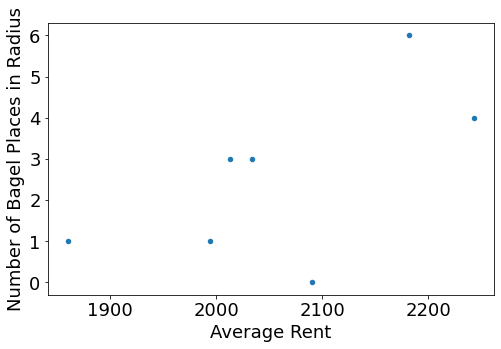

In [52]:
merged.plot(x='Average Rent', y='Number of Bagel Places in Radius', kind='scatter',figsize=(8, 5))

In [53]:
#looks like rent is correlated positively with the number of bagel shops

Step 4: k-means

In [54]:
pip install -U scikit-learn

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 22.3 MB 14.1 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1
Note: you may need to restart the kernel to use updated packages.


In [55]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

In [56]:
#make dataframe with only rents and number of bagel places
for_kmeans = merged[['Average Rent', 'Number of Bagel Places in Radius']].copy()

In [57]:
kclusters = 3
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(for_kmeans)

In [60]:
kmeans.labels_[0:7] 

array([0, 2, 2, 2, 0, 2, 1], dtype=int32)

In [61]:
Cluster_Labels = [0, 2, 2, 2, 0, 2, 1]

In [63]:
#add cluster labels to dataframe
merged['Cluster Labels'] = Cluster_Labels
merged

,Borough,Neighborhood,Latitude,Longitude,Average Rent,Number of Bagel Places in Radius,Cluster Labels
0,Queens,Jackson Heights,40.751981,-73.882821,2243.0,4,0
1,Queens,Elmhurst,40.744049,-73.881656,2013.0,3,2
2,Queens,Corona,40.742382,-73.856825,2090.0,0,2
3,Queens,Maspeth,40.725427,-73.896217,2034.0,3,2
4,Queens,Rego Park,40.728974,-73.857827,2182.0,6,0
5,Queens,Queensboro Hill,40.744572,-73.825809,1994.0,1,2
6,Queens,Pomonok,40.734936,-73.804861,1860.0,1,1


In [65]:
#finally, make a map

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [66]:
#done! :-)